# Multisectoral energy system with oemof
## Create a simple energy system

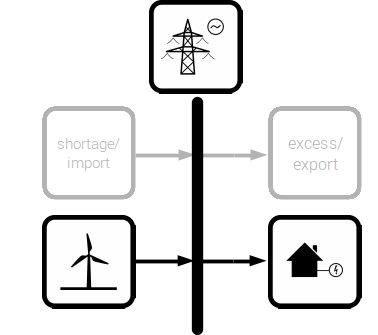

### Initialize energy system

In [1]:
from oemof.solph import EnergySystem
import pandas as pd

# initialize energy system
energysystem = EnergySystem(timeindex=pd.date_range('1/1/2016', 
                                                    periods=168, 
                                                    freq='H'))

### Import input data

In [2]:
# import example data with scaled demands and feedin timeseries of renewables 
# as dataframe
data = pd.read_csv("data/example_data.csv", sep=",", index_col='timeindex', parse_dates=['timeindex'])

### Add entities to energy system

In [3]:
from oemof.solph import Bus, Flow, Sink, Source, LinearTransformer

### BUS
# create electricity bus
b_el = Bus(label="b_el")

# add excess sink to help avoid infeasible problems
Sink(label="excess_el",
     inputs={b_el: Flow()})
Source(label="shortage_el",
       outputs={b_el: Flow(variable_costs=1000)})

### DEMAND
# add electricity demand
Sink(label="demand_el",
     inputs={b_el: Flow(nominal_value=85,
                        actual_value=data['demand_el'],
                        fixed=True)})

### SUPPLY
# add wind and pv feedin
Source(label="wind",
       outputs={b_el: Flow(actual_value=data['wind'],
                           nominal_value=60,
                           fixed=True)});
Source(label="pv",
       outputs={b_el: Flow(actual_value=data['pv'],
                           nominal_value=200,
                           fixed=True)});

### Optimize energy system and plot results

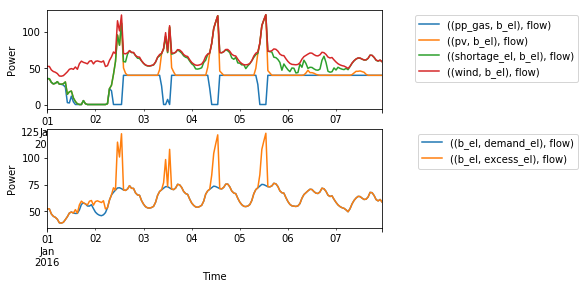

In [10]:
from oemof.solph import OperationalModel
from oemof.outputlib import processing, views
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def optimize(energysystem):
    
    ### optimize
    # create operational model
    om = OperationalModel(es=energysystem)

    # solve using the cbc solver
    om.solve(solver='cbc',
             solve_kwargs={'tee': False})

    # save LP-file
    om.write('sector_coupling.lp', io_options={'symbolic_solver_labels': True})

    # generic result object
    #results = processing.results(om=om)
    
    # write back results from optimization object to energysystem
    #om.results();
    return om


def plot(om, bus_label):
    """
    Plots...

    Parameters
    ----------
    om : oemof.solph.models.OperationalModel
    bus_label : String
        Label of bus to be plotted.
    """
    
    def get_flows_to_and_from_bus(node_results_flows):
        "Function to devide flows into ingoing and outgoing flows."
        flows = list(node_results_flows.columns)
        to_flows = []
        from_flows = []
        for flow in flows:
            if flow[0][0] == bus_label:
                from_flows.append(flow)
            elif flow[0][1] == bus_label:
                to_flows.append(flow)
            else:
                print("{} is neither from nor to bus.".format(flow))
        return (to_flows, from_flows)

    # node_results is a dictionary keyed by 'scalars' and 'sequences'
    # holding respective data in a pandas Series and DataFrame.
    node_results = views.node(om.results(), bus_label)
    node_results_flows = node_results['sequences']
    to_flows, from_flows = get_flows_to_and_from_bus(node_results_flows)

    plt.figure(1)
    ax1 = plt.subplot(2,1,1)
    node_results_flows[to_flows].plot(kind='line', stacked=True, ax=ax1)
    ax2 = plt.subplot(2,1,2)
    node_results_flows[from_flows].plot(kind='line', stacked=True, ax=ax2)

    ax1.legend(loc='upper right', bbox_to_anchor=(1.6, 1.0))
    ax2.legend(loc='upper right', bbox_to_anchor=(1.6, 1.0))
    ax1.set_ylabel('Power')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Power')
    plt.show()
    
om = optimize(energysystem)
plot(om, 'b_el')

## Adding the gas sector

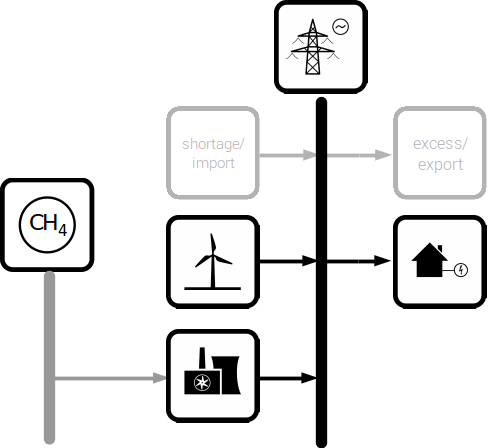

In order to add a gas power plant, a gas ressource bus is needed. The gas power plant connects the gas and electricity busses and thereby couples the gas and electricity sector.

In [5]:
# add gas bus
b_gas = Bus(label="b_gas",
            balanced=False)

# add gas power plant
LinearTransformer(label="pp_gas",
                  inputs={b_gas: Flow(summed_max_flow=200)},
                  outputs={b_el: Flow(nominal_value=40,
                                      variable_costs=40)},
                  conversion_factors={b_el: 0.50});

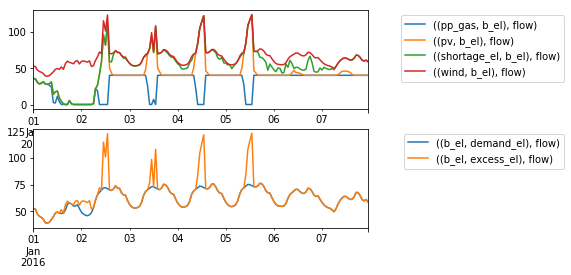

In [6]:
om = optimize(energysystem)
plot(om, 'b_el')

## Adding the heat sector

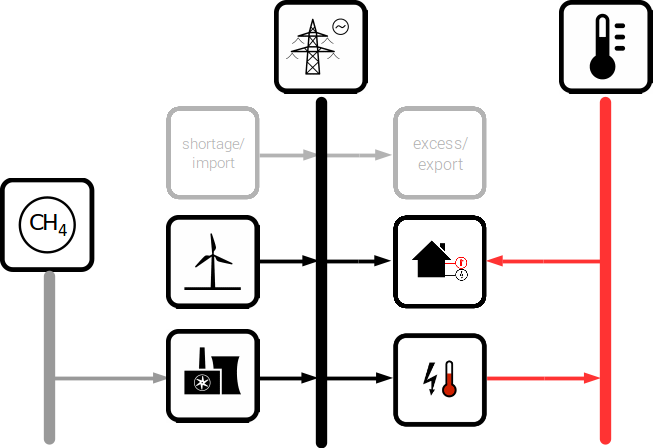

The heat sector is added and coupled to the electricity sector similarly to the gas sector. The same component, the LinearTransformer, is used to couple the two sectors. Only through its parametrisation it becomes a heater rod or a heat pump.


In [11]:
# add heat bus
b_heat = Bus(label="b_heat",
             balanced=True)

# add heat demand
Sink(label="demand_th",
     inputs={b_heat: Flow(nominal_value=60,
                        actual_value=data['demand_th'],
                        fixed=True)})

# add heater rod
LinearTransformer(label="heater_rod",
                  inputs={b_el: Flow()},
                  outputs={b_heat: Flow(variable_costs=10)},
                  conversion_factors={b_heat: 0.98});

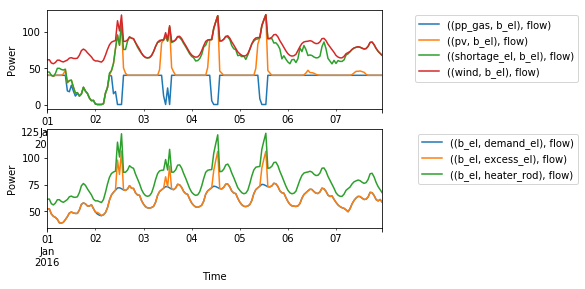

In [12]:
om = optimize(energysystem)
plot(om, 'b_el')

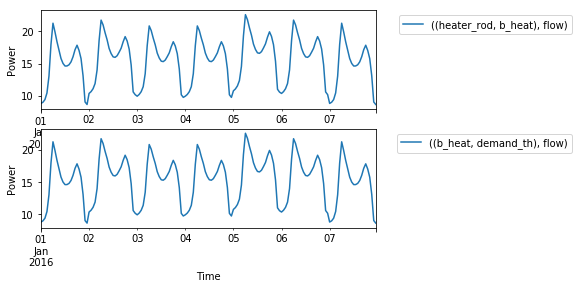

In [13]:
plot(om, 'b_heat')

### Adding a heat pump

There are different ways to model a heat pump. Here the approach of precalculating a COP and using this as a conversion factor for the LinearTransformer is used. Another approach is to use the LinearN1Transformer that has two inputs - electricity and heat from a heat source. See the solph example "simple_dispatch".

In [14]:
# COP can be calculated beforehand, assuming the heat reservoir temperature 
# is infinite random timeseries for COP
import numpy as np
COP = np.random.uniform(low=3.0, high=5.0, size=(168,))

# add heater rod
#LinearTransformer(label="heater_rod",
#                  inputs={b_el: Flow()},
#                  outputs={b_heat: Flow(variable_costs=10)},
#                  conversion_factors={b_heat: 0.98});

# add heat pump
LinearTransformer(label="heat_pump",
                  inputs={b_el: Flow()},
                  outputs={b_heat: Flow(nominal_value=20,
                                        variable_costs=10)},
                  conversion_factors={b_heat: COP});

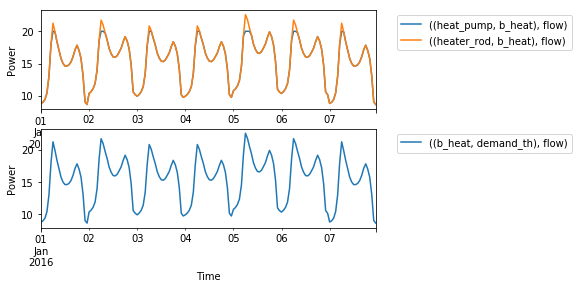

In [15]:
om = optimize(energysystem)
plot(om, 'b_heat')

### Adding a combined heat and power plant

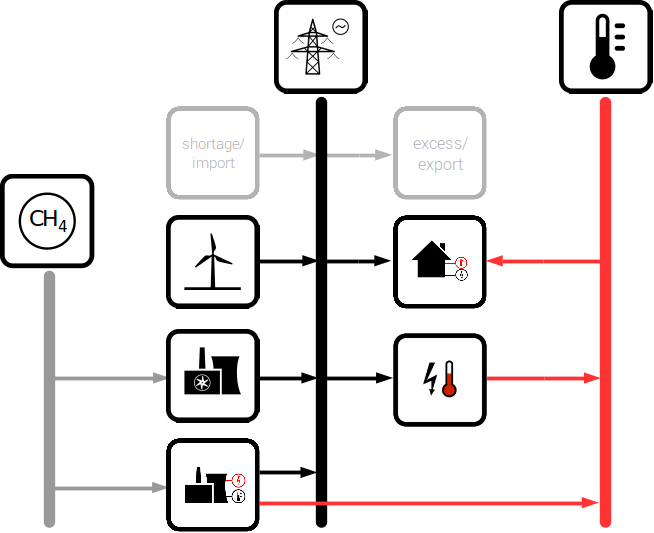

The combined heat and power plant couples the gas, electricity and heat sector.

In [16]:
# add CHP with fixed ratio of heat and power (back-pressure turbine)
LinearTransformer(label='pp_chp',
                  inputs={b_gas: Flow()},
                  outputs={b_el: Flow(nominal_value=30,
                                      variable_costs=42),
                           b_heat: Flow(nominal_value=40)},
                  conversion_factors={b_el: 0.3,
                                      b_heat: 0.4});

In [17]:
from oemof.solph.components import VariableFractionTransformer

# add CHP with variable ratio of heat and power (extraction turbine)
VariableFractionTransformer(label='pp_chp_extraction',
                            inputs={b_gas: Flow()},
                            outputs={b_el: Flow(nominal_value=30,
                                                variable_costs=42),
                                     b_heat: Flow(nominal_value=40)},
                            conversion_factors={b_el: 0.3,
                                                b_heat: 0.4},
                            conversion_factor_single_flow={b_el: 0.5});

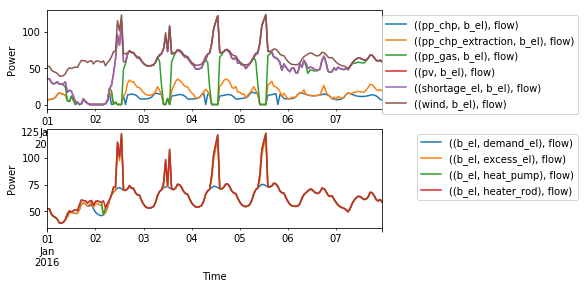

In [18]:
om = optimize(energysystem)
plot(om, 'b_el')

## Adding the mobility sector

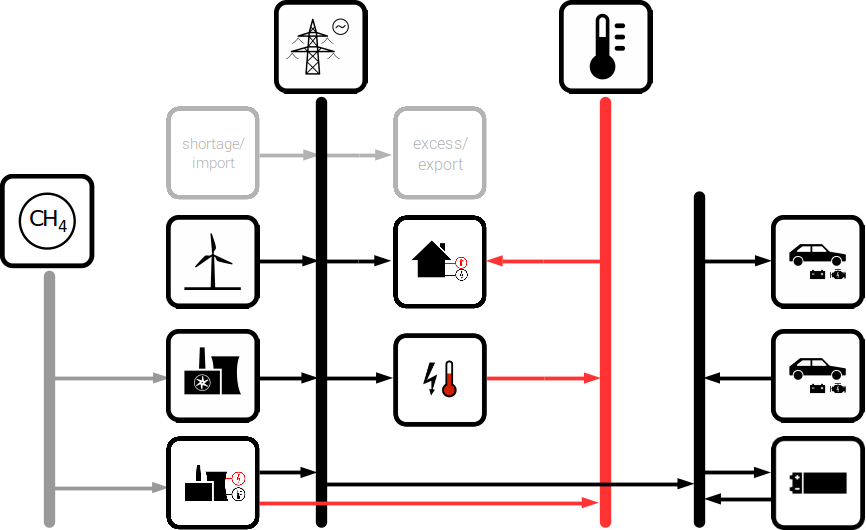

In [19]:
from oemof.solph.components import GenericStorage as Storage

charging_power = 20
bev_battery_cap = 50

# add mobility bus
b_bev = Bus(label="b_bev",
            balanced=True)

# add transformer to transport electricity from grid to mobility sector
LinearTransformer(label="transport_el_bev",
                  inputs={b_el: Flow()},
                  outputs={b_bev: Flow(variable_costs=10,
                                       nominal_value=charging_power,
                                       max=data['bev_charging_power'])},
                  conversion_factors={b_bev: 1.0})
    
# add BEV storage
Storage(label='bev_storage',
        inputs={b_bev: Flow()},
        outputs={b_bev: Flow()},
        nominal_capacity=bev_battery_cap,
        capacity_min=data['bev_cap_min'],
        capacity_max=data['bev_cap_max'],
        capacity_loss=0.00,
        initial_capacity=None,
        inflow_conversion_factor=1.0,
        outflow_conversion_factor=1.0,
        nominal_input_capacity_ratio=1.0,
        nominal_output_capacity_ratio=1.0,
        fixed_costs=35)

# add sink for leaving vehicles
Sink(label="leaving_bev",
     inputs={b_bev: Flow(nominal_value=bev_battery_cap,
                         actual_value=data['bev_sink'],
                         fixed=True)})

# add source for returning vehicles
Source(label="returning_bev",
       outputs={b_bev: Flow(nominal_value=bev_battery_cap,
                            actual_value=data['bev_source'],
                            fixed=True)});

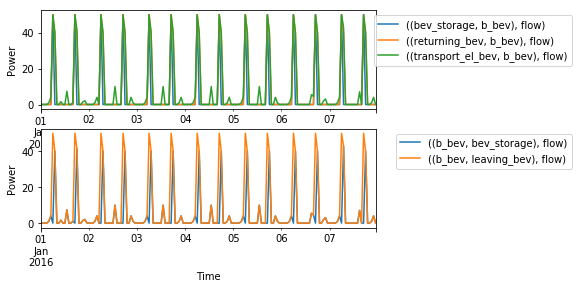

In [20]:
om = optimize(energysystem)
plot(om, 'b_bev')

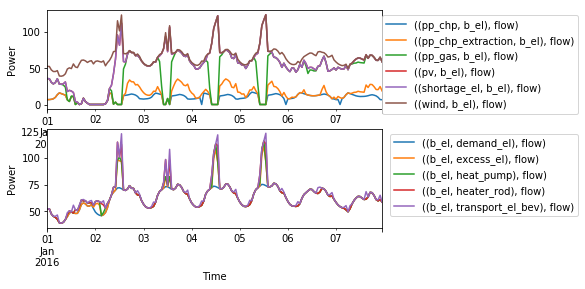

In [21]:
plot(om, 'b_el')